Author:  Hao Jiang
## Goal for this notebook
 * Clean the data
  * Categorical data convert
  * Deal with n/a values
  * Deal with skewed numerical values
 
Credit: Some basic ideas such as converting skewed data comes from this kernal:
https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# combine the data and list the names of the columns
all_data = pd.concat((train.iloc[:,1:-1], test.iloc[:,1:-1]))
# check datasize
all_data.shape

(2919, 79)

In [4]:
# check na value count
nullCnt = pd.DataFrame({'nullNums' : all_data.isnull().sum()})
nullCnt['DataType'] = all_data[nullCnt.index].dtypes
print nullCnt[nullCnt['nullNums'] > 0].sort_values(by = 'DataType')

               nullNums DataType
GarageArea            1  float64
TotalBsmtSF           1  float64
BsmtFinSF1            1  float64
BsmtFinSF2            1  float64
GarageYrBlt         159  float64
BsmtFullBath          2  float64
BsmtHalfBath          2  float64
GarageCars            1  float64
BsmtUnfSF             1  float64
MasVnrArea           23  float64
LotFrontage         486  float64
GarageType          157   object
KitchenQual           1   object
MasVnrType           24   object
MiscFeature        2814   object
PoolQC             2909   object
SaleCondition      1459   object
SaleType              1   object
MSZoning              4   object
GarageQual          159   object
Alley              2721   object
GarageCond          159   object
Functional            2   object
FireplaceQu        1420   object
Fence              2348   object
Exterior2nd           1   object
Exterior1st           1   object
Electrical            1   object
BsmtQual             81   object
BsmtFinTyp

In [5]:
# Convert all object to categorical data
objColumns = all_data.dtypes[all_data.dtypes == 'object'].index

# There are several columns of categorical data represented as numeric. Convert them to categorical ones
for name in objColumns | pd.Index(['MSSubClass']):
    all_data[name] = all_data[name].astype("category")

In [6]:
# Convert all skewed numerical data and salePrice with log(1+p)
target = np.log1p(train['SalePrice'])

In [7]:
#  Try to convert skewed data, first check the columns
numColumns = all_data.dtypes[all_data.dtypes != "category"].index
skewed_feats = all_data[numColumns].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index

print skewed_feats

Index([u'1stFlrSF', u'2ndFlrSF', u'3SsnPorch', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtHalfBath', u'BsmtUnfSF', u'EnclosedPorch', u'GrLivArea',
       u'KitchenAbvGr', u'LotArea', u'LotFrontage', u'LowQualFinSF',
       u'MasVnrArea', u'MiscVal', u'OpenPorchSF', u'PoolArea', u'ScreenPorch',
       u'TotRmsAbvGrd', u'TotalBsmtSF', u'WoodDeckSF'],
      dtype='object')


In [8]:
# The skewed features seems find. Lets convert them
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Let's take a look at null data.For numerical data, GarageYrBlt, MasVnrArea and LotFrontage seems to have too many nulls.
Let's see if we could guess the right value from other data

In [9]:
# GarageYrBlt
garageFeats = pd.Index([name for name in all_data.columns if u'Garage' in name])
all_data.loc[all_data['GarageYrBlt'].isnull(), garageFeats].head()

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
39,0.0,0.0,NaN,NaN,NaN,NaN,NaN
48,0.0,0.0,NaN,NaN,NaN,NaN,NaN
78,0.0,0.0,NaN,NaN,NaN,NaN,NaN
88,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN


It seems that when there's no garage, YrBlt would be null and area data 0. Let's fill the null data for them

In [10]:
for name in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    all_data.loc[all_data['GarageType'].isnull(),[name]] = 0

In [11]:
# Now let's handle LotFrontage
lotFeats = [name for name in all_data.columns if u'Lot' in name]
all_data.loc[all_data['LotFrontage'].isnull(), lotFeats].head()

,LotArea,LotConfig,LotFrontage,LotShape
7,9.247925,Corner,NaN,IR1
12,9.470317,Inside,NaN,IR2
14,9.298443,Corner,NaN,IR1
16,9.327412,CulDSac,NaN,IR1
24,9.017605,Inside,NaN,IR1


Let's take a look at the none null lot-related data and see if there's any correlation

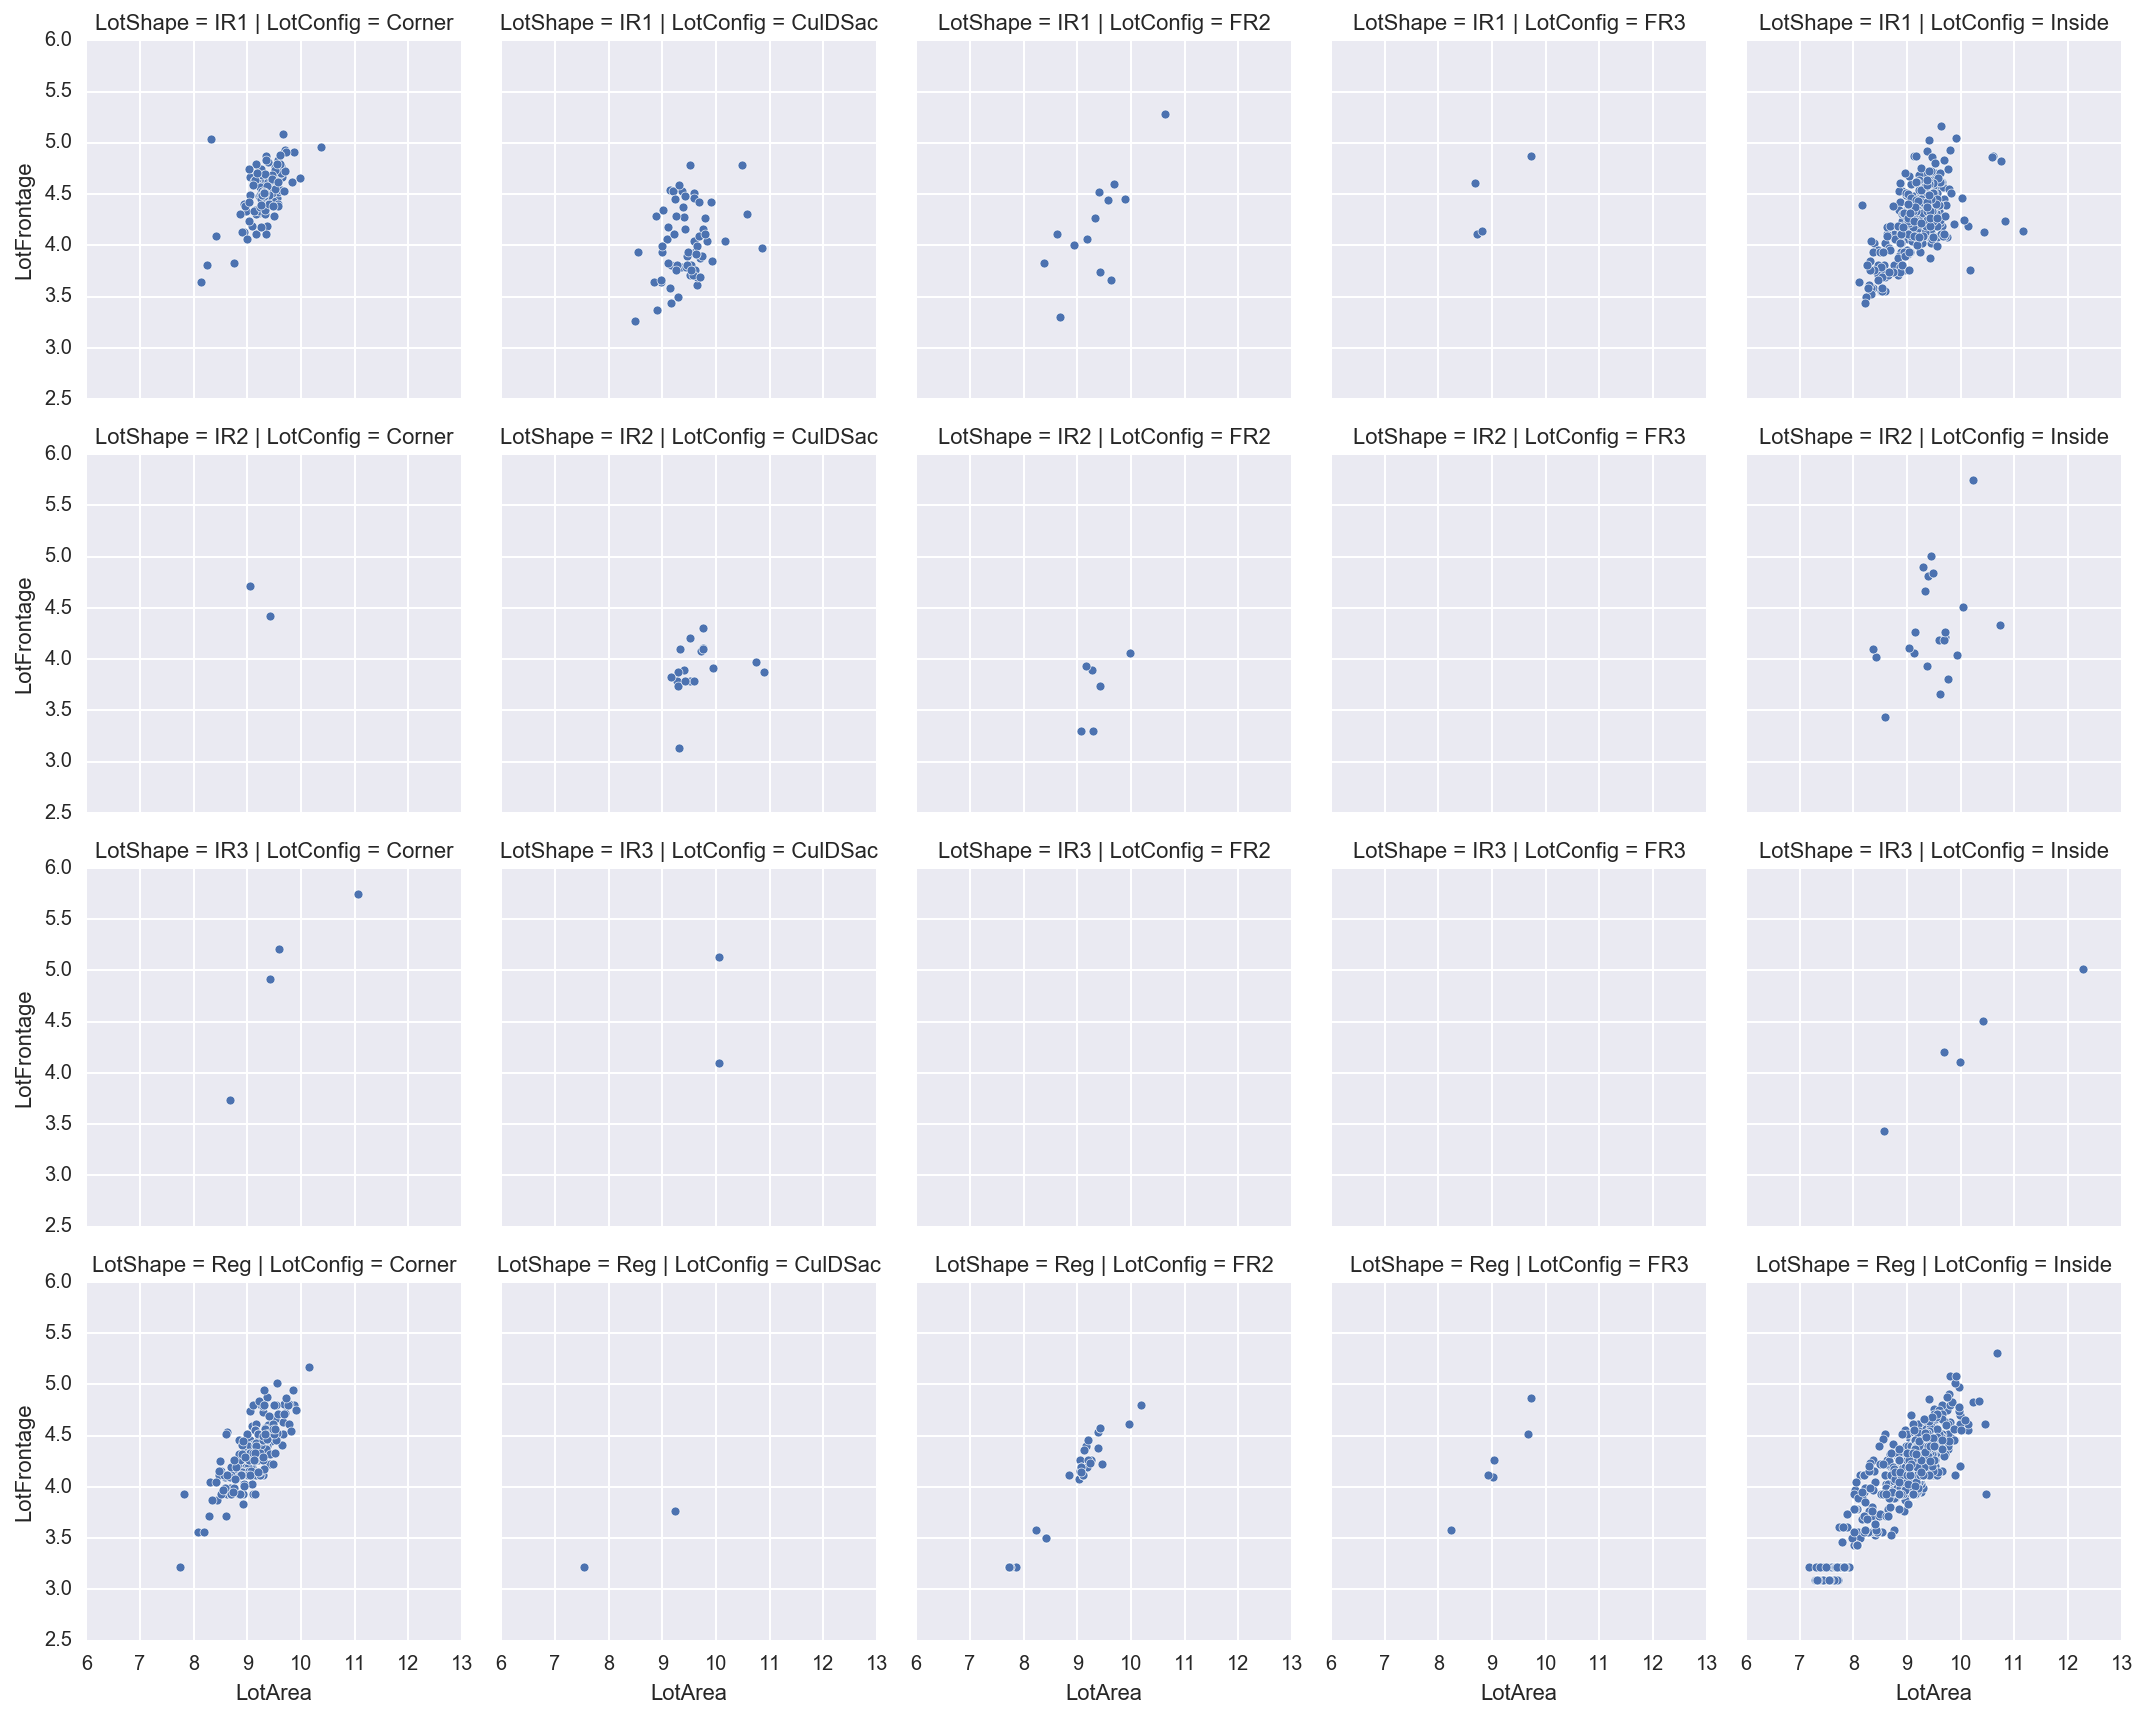

In [12]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
facet = sns.FacetGrid(all_data.loc[all_data['LotFrontage'].notnull(), lotFeats], col="LotConfig",  row="LotShape")
facet.map(matplotlib.pyplot.scatter, "LotArea", "LotFrontage", edgecolor="w")

The LotShape and LotConfig distribution for null value is as followed:

In [13]:
pd.pivot_table(all_data.loc[all_data['LotFrontage'].isnull(), lotFeats], values=['LotArea'], index=['LotShape'], columns=['LotConfig'], aggfunc=np.count_nonzero)

LotArea                          
LotConfig  Corner CulDSac   FR2  FR3 Inside
LotShape                                   
IR1          73.0    76.0  12.0  3.0  157.0
IR2          11.0     9.0   3.0  NaN    5.0
IR3           2.0     1.0   NaN  NaN    2.0
Reg          18.0     1.0   5.0  1.0  107.0

Basically, null data distribution is similar to none-null ones. And LotFrontage seems to be somewhat linear correlated to LotArea. So let's just predict null LotFrontage with LotArea with linear regression.

In [14]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(all_data.loc[all_data['LotFrontage'].notnull(), ['LotArea']], all_data.loc[all_data['LotFrontage'].notnull(), ['LotFrontage']])
all_data.loc[all_data['LotFrontage'].isnull(), ['LotFrontage']] = reg.predict(all_data.loc[all_data['LotFrontage'].isnull(), ['LotArea']])

In [15]:
# For MasVnrArea it seems that when there is none Masonry veneer the area data apreas null
all_data.loc[all_data['MasVnrType'].isnull(), 'MasVnrArea'] = 0

In [16]:
# There're several pairs of feature that should be merged when one-hot encoded

# Deal with Exterior
for name in all_data["Exterior1st"].unique().dropna():
    all_data[name] = 1 * ((all_data["Exterior1st"] == name) | (all_data["Exterior2nd"] == name))


# Deal with Condition
for name in all_data["Condition1"].unique().dropna():
    all_data[name] = 1 * ((all_data["Condition1"] == name) | (all_data["Condition2"] == name))


# Deal with BsmtFinType
for name in all_data["BsmtFinType1"].unique().dropna():
    all_data[name] = all_data["BsmtFinSF1"] * (all_data["BsmtFinType1"] == name) +  all_data["BsmtFinSF2"] * (all_data["BsmtFinType2"] == name)


In [17]:
# Drop those features that we have converted already

all_data = all_data.drop(['Exterior1st','Exterior2nd'], axis=1)
all_data = all_data.drop(['Condition1','Condition2'], axis=1)
all_data = all_data.drop(['BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2'], axis=1)

In [18]:
# one-hot encode category data
all_data = pd.get_dummies(all_data)
print all_data.shape

(2919, 271)


In [19]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [20]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,6.753438,6.751101,0.0,3,1.0,0.000000,5.017280,0.000000,0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,7.141245,0.000000,0.0,3,0.0,0.693147,5.652489,0.000000,1,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,6.825460,6.765039,0.0,3,1.0,0.000000,6.075346,0.000000,1,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,6.869014,6.629363,0.0,3,1.0,0.000000,6.293419,5.609472,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,7.044033,6.960348,0.0,4,1.0,0.000000,6.196444,0.000000,1,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
